In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from PIL import Image
from sklearn.model_selection import train_test_split

In [53]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [54]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [55]:
train_df['label'] = train_df.apply(lambda x: np.argmax(x[1:]),axis=1)

In [56]:
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [57]:
img = Image.open('images/Train_0.jpg')
nparr  = np.asarray(img)

In [58]:
nparr.shape

(1365, 2048, 3)

In [59]:
import os
# label_encode = {0:"healthy",1:"multiple_diseases",2:"rust",3:"scab"}

In [60]:
train_df.shape

(1821, 6)

In [61]:
train_df.iloc[0]['image_id']

'Train_0'

In [62]:
train_df,validate_df = train_test_split(train_df,test_size=0.3)

In [63]:
new_img_size = (256,256)

In [64]:
%%time
img = Image.open(f'images/{train_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_train = np.array([np.asarray(img)])

for i in range(1,train_df.shape[0]):
    img = Image.open(f'images/{train_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_train = np.concatenate((images_train,np.array([np.asarray(img)])),axis=0)

Wall time: 1min 48s


In [65]:
%%time
img = Image.open(f'images/{validate_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_validate = np.array([np.asarray(img)])
for i in range(1,validate_df.shape[0]):
    img = Image.open(f'images/{validate_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_validate = np.concatenate((images_validate,np.array([np.asarray(img)])),axis=0)

Wall time: 31.1 s


In [66]:
%%time
img = Image.open(f'images/{test_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_test = np.array([np.asarray(img)])
for i in range(1,test_df.shape[0]):
    img = Image.open(f'images/{test_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_test = np.concatenate((images_test,np.array([np.asarray(img)])),axis=0)

Wall time: 3min 8s


In [67]:
print("Training set is of shape : ",images_train.shape)
print("Validation set is of shape : ",images_validate.shape)
print("Test set is of shape : ",images_test.shape)

Training set is of shape :  (1274, 256, 256, 3)
Validation set is of shape :  (547, 256, 256, 3)
Test set is of shape :  (1821, 256, 256, 3)


## Model building

Lets start with a base CNN model

In [68]:
# model = Sequential([
#     layers.Rescaling(1./255.,input_shape=(224,224,3)),
#     layers.Conv2D(8,(3,3),activation='relu'),
#     layers.MaxPooling2D(2,2),
#     layers.Dropout(0.2),
#     layers.Conv2D(16,(3,3),activation='relu'),
#     layers.MaxPooling2D(2,2),
#     layers.Dropout(0.2),
#     layers.Conv2D(32,(3,3),activation='relu'),
#     layers.MaxPooling2D(2,2),
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(256,activation='relu'),
#     layers.Dense(64,activation='relu'),
#     layers.Dense(4,activation='softmax'),   
# ])
# model.build()

In [69]:
# model.compile(
#     optimizer='adam',
#     loss = tf.losses.SparseCategoricalCrossentropy(),
#     metrics=['accuracy']
# )

In [70]:
# batch_size = 32
# epochs = 15

# model.fit(
#     images_train,
#     train_df['label'],
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(images_validate,validate_df['label'])
# )

In [71]:
data_augmentaion = Sequential([
    layers.RandomRotation(factor=(-0.2,0.2),seed = 123),
    layers.RandomZoom(0.1),
    layers.RandomFlip('horizontal'),
])

In [72]:
model = Sequential([
    layers.Rescaling(1./255.,input_shape=(256,256,3)),
    data_augmentaion,
    layers.Conv2D(8,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(4,activation='softmax'),   
])
model.build()

In [73]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 8)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 127, 127, 8)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 16)      1168      
                                                      

In [74]:

model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

batch_size = 64
epochs = 50

history = model.fit(
    images_train,
    train_df['label'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(images_validate,validate_df['label'])
)

Epoch 1/50
20/20 [==============================] - 6s 109ms/step - loss: 1.3012 - accuracy: 0.3375 - val_loss: 1.2716 - val_accuracy: 0.3729
Epoch 2/50
20/20 [==============================] - 1s 66ms/step - loss: 1.2451 - accuracy: 0.3736 - val_loss: 1.2708 - val_accuracy: 0.4132
Epoch 3/50
20/20 [==============================] - 1s 65ms/step - loss: 1.2297 - accuracy: 0.3744 - val_loss: 1.2263 - val_accuracy: 0.4314
Epoch 4/50
20/20 [==============================] - 1s 69ms/step - loss: 1.2092 - accuracy: 0.4262 - val_loss: 1.2263 - val_accuracy: 0.4406
Epoch 5/50
20/20 [==============================] - 2s 78ms/step - loss: 1.2101 - accuracy: 0.4113 - val_loss: 1.1874 - val_accuracy: 0.4186
Epoch 6/50
20/20 [==============================] - 1s 68ms/step - loss: 1.1747 - accuracy: 0.4639 - val_loss: 1.1643 - val_accuracy: 0.4771
Epoch 7/50
20/20 [==============================] - 2s 76ms/step - loss: 1.0986 - accuracy: 0.5510 - val_loss: 1.0720 - val_accuracy: 0.5539
Epoch 8/50
2

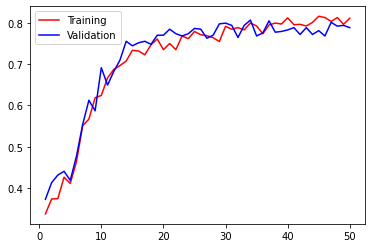

In [75]:
train_acc = history.history['accuracy']
validate_acc = history.history['val_accuracy']
epoch_ = range(1,epochs+1)

plt.plot(epoch_,train_acc,'r',label='Training')
plt.plot(epoch_,validate_acc,'b',label='Validation')
plt.legend()
plt.show()

In [76]:
predictions = model.predict(images_test)

In [77]:
predictions.shape

(1821, 4)

In [78]:
predictions_df = pd.DataFrame(np.round(predictions,2))
submission_df = pd.concat([test_df,predictions_df],axis=1)

In [79]:
submission_df.head()

,image_id,0,1,2,3
0,Test_0,0.00,0.04,0.96,0.00
1,Test_1,0.00,0.40,0.60,0.00
2,Test_2,0.19,0.07,0.01,0.72
3,Test_3,0.83,0.02,0.05,0.10
4,Test_4,0.00,0.02,0.98,0.00


In [80]:
submission_df.rename(columns={k:label_encode[k] for k in range(0,4)}).to_csv("submission.csv",index=False)